In [1]:
%load_ext autoreload
import glob
import shutil
import nibabel
import pandas as pd
import numpy as np
import os
from IPython.core.debugger import set_trace
from datetime import datetime
from collections import defaultdict, Counter
from matplotlib import pyplot as plt
from tqdm import notebook, tqdm
from joblib import Parallel, delayed
from tensorboardX import SummaryWriter  

import torchio as tio
import torchvision
import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import yaml
from easydict import EasyDict as edict

from utils import get_capacity, create_dicts, normalize, load, video, video_comparison, save, DiceScoreBinary, check_patch
from datasets import BrainMaskDataset

from multiprocessing import cpu_count
N_CPU = cpu_count()

from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

from IPython.core.display import display, HTML
from celluloid import Camera
from itertools import product

SEED = 42
%autoreload 2

In [2]:
!nvidia-smi

Sun Jan 23 16:05:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:02:00.0  On |                  N/A |
| 22%   41C    P8    26W / 250W |   3090MiB / 12211MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  Off  | 00000000:03:00.0 Off |                  N/A |
| 34%   

In [143]:
labels_components = np.load('label_info_v2.npy', allow_pickle=True).item()
single_component_keys = {k for k,v in labels_components.items() if len(v['cc3d'][0]) != 2}

labels_broken = {'43','n27','33','37', '9', 'n31',
                 'n30', 'n10', 'n8', '47', '6',
                 '25', '12'}.union(single_component_keys)

оценить реф. точки в мозге, для прибл. оценки координаты патча
nasion
cdusials

In [144]:
root = '/nfs/garfield/ibulygin/preprocessed_data_v2'
root_label = os.path.join(root, 'label')


feature_paths_templates = {
      'label':os.path.join(root, 'label/{label}.nii'),
      'mask':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_desc-brain_mask.nii.gz'),
      'curv':os.path.join(root, 'curv/norm-{label}.nii'),
      'sulc':os.path.join(root, 'sulc/norm-{label}.nii'),
      'thickness':os.path.join(root, 'thickness/norm-{label}.nii'),
      'bT1':os.path.join(root, 'bluring-T1/sub-{label}_T1blurring-in-volume.nii.gz'),
      'bT2':os.path.join(root, 'bluring-T2/sub-{label}_T2blurring-in-volume.nii.gz'),
      'T1w':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'),
      'T2':os.path.join(root, 'T2/{label}.nii'),
      'CSF':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-CSF_probseg.nii.gz'),
      'GM':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-GM_probseg.nii.gz'),
      'WM':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-WM_probseg.nii.gz'),
        }

paths_dict = create_dicts(root_label,
                         feature_paths_templates, 
                         broken_labels=labels_broken)

No curv for n20
No curv for 53
No curv for 57
No curv for G015
No curv for 52
No curv for 51
No curv for 59
No curv for 50
No curv for n23
No bT1 for 27
No curv for 58
No curv for n25


In [145]:
len(paths_dict)

63

In [12]:
def calculate_patches(k, 
                      paths_dict, 
                      labels_components, 
                      aug_steps, 
                      patch_size, 
                      fcd_threshold):
    
    patches = []
    path_dict = paths_dict[k]
    label_info = labels_components[k]
    center = label_info['center']
    label = nibabel.load(path_dict['label']).get_fdata()
    mask = nibabel.load(path_dict['mask']).get_fdata() > 0
    X,Y,Z = mask.shape
    pad = PATCH_SIZE//2
    n_fcd = label.sum()
    
    # get rid of a mid-brain
    X_mean = X//2
    thresh_mask = (np.arange(X) < (X_mean - pad)) | (np.arange(X) > (X_mean + pad))
    thresh_mask = np.tile(thresh_mask, (Y,Z,1)).transpose(2,0,1)
    mask = mask_tensor*(thresh_mask > 0)
    xyz_grid = np.stack(np.meshgrid(np.arange(X), np.arange(Y), np.arange(Z), indexing='ij'), -1)
    xyz_grid = xyz_grid[mask_tensor]
    
    for x,y,z in tqdm(xyz_grid):
        
        patch_info = check_patch(x,y,z)
        info_patch_nonfcd = patch_info
        info_patch_nonfcd['patch_center'] = np.array([x,y,z])
        info_patch_nonfcd['label'] = k
        
        
        
        patches.append(info_patch_nonfcd)
    
    return patches

In [3]:
for name in paths_dict.keys():
    
    patch_size = 32
    patches = []
    path_dict = paths_dict[name]
    label_info = labels_components[name]
    center = label_info['center']
    label = (nibabel.load(path_dict['label']).get_fdata() > 0).astype(int)
    mask = nibabel.load(path_dict['mask']).get_fdata() > 0
    
    X,Y,Z = mask.shape
    pad = patch_size//2
    n_fcd = label.sum()

    # get rid of a mid-brain
    # X_mean = X//2
    # thresh_mask = (np.arange(X) < (X_mean - pad)) | (np.arange(X) > (X_mean + pad))
    # thresh_mask = np.tile(thresh_mask, (Y,Z,1)).transpose(2,0,1)
    # mask = mask*(thresh_mask > 0)

    xyz_grid = np.stack(np.meshgrid(np.arange(X), np.arange(Y), np.arange(Z), indexing='ij'), -1)
    xyz_grid = xyz_grid[mask]

    for x,y,z in tqdm(xyz_grid):

        patch_info = check_patch(x,y,z, mask, label, pad)
        
        if patch_info is not None:

            patch_info['label'] = name
            patch_info['n_fcd'] = n_fcd

            patches.append(patch_info)


    pd.DataFrame(patches).to_csv(f'patches_dataframes/label-{name}_ps32_notrim')

In [149]:
balance = []

for k in tqdm(paths_dict.keys()):
    df = pd.read_csv(f'patches_dataframes/label-{k}_ps32_notrim', 
                                        index_col=0)
          
    df['fcd_percentage'] = df['n_label'] / df['n_fcd']
    df['target'] = (df['fcd_percentage'] >= 0.5).astype(int)
    drop_index = df.query(f"fcd_percentage>0 & fcd_percentage<{0.5}").index
    df.drop(index=drop_index, inplace=True)
    
    balance.append(df['target'].sum()/df.shape[0])
          
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [06:57<00:00,  6.63s/it]


In [168]:
# 1/(np.mean(balance))

In [298]:
df = pd.read_csv(f'patches_dataframes/label-38_ps32_notrim', 
                index_col=0)

In [171]:
symmetry = tio.RandomFlip(axes=0) 
bias = tio.RandomBiasField(coefficients=0.3)
noise = tio.RandomNoise(std=(0,1e-3))
affine = tio.RandomAffine(scales=(0.9, 1.1, 0.9, 1.1, 0.9, 1.1), 
                     degrees=5,
                     translation=(1,1,1),
                     center='image',
                     default_pad_value=0)
rescale = tio.RescaleIntensity(out_min_max=(0, 1))
augmentation = tio.Compose([symmetry, bias, noise, affine, rescale])

In [177]:
tensor_dict = torch.load('/nfs/garfield/ibulygin/tensors_v2/tensor_1')

In [185]:
features = set(tensor_dict.keys()) - {'label', 'mask'}
brain_tensor_torch = torch.stack([tensor_dict[f] for f in features], dim=0)#.unsqueeze(0)

In [186]:
brain_tensor_torch_aug = augmentation(brain_tensor_torch)

In [189]:
brain_tensor_torch_aug.min()

tensor(0.)

In [204]:
# df = pd.read_csv('foo', index_col=0, dtype={'x': int, 'y': int, 'z': int,
#                                           'p_mask':float,
#                                            'n_label':int,
#                                            'label':int,
#                                            'n_fcd':int,
#                                            'fcd_percentage':float,
#                                            'target':int})

In [299]:
df['target'] = (df['n_label'] > 0).astype(int)

In [300]:
target_ind = np.array(df.query('target==1').index.tolist())
non_target_ind = df.query('target!=1').index
non_target_ind_sample = np.random.choice(non_target_ind, size=len(target_ind), replace=False)
new_indexes = np.concatenate([target_ind,non_target_ind_sample])
new_indexes = pd.core.indexes.numeric.Int64Index(data=new_indexes)
df = df.loc[new_indexes]

In [ ]:
os.path.isfile()

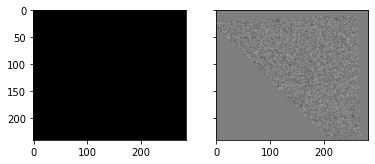

In [187]:
plt.ioff()
camera = video_comparison([brain_tensor_torch[0].numpy(), brain_tensor_torch_aug[0].numpy()],
                          n_slides=132)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [ ]:
class PatchesDataset(Dataset):

    def __init__(self, root, config, train=True):
        
        self.root = root
        self.train = train
        self.features = config.dataset.features
        self.patch_size = config.dataset.patch_size
        self.fcd_threshold = config.dataset.fcd_threshold
        
        self.patch_dataframe_path = config.dataset.patch_dataframe_path
        self.metadata = np.load(self.metadata_path, allow_pickle=True).item()
        metadata_key = 'train' if self.train else 'test'
        self.labels = self.metadata[metadata_key]
        
        self.df = pd.concat([self.process_df(pd.read_csv(f'{self.patch_dataframe_path}/label-{k}_ps{self.patch_size}_notrim', 
                                        index_col=0)) \
                               for k in self.labels])
        
    def process_df(self, df):
            
        df['fcd_percentage'] = df['n_label'] / df['n_fcd']
        df['target'] = (df['fcd_percentage'] >= self.fcd_threshold).astype(int)
        drop_index = df.query(f"fcd_percentage>0 & fcd_percentage<{self.fcd_threshold}").index
        df.drop(index=drop_index, inplace=True)

        return df[['x','y','z', 'label']]

    def __getitem__(self, idx):

        info = self.df.iloc[idx]
        x = info.x
        y = info.y
        z = info.z
        label = info.label
        target = torch.tensor([info.target])
        
        tensor_path = os.path.join(self.root, f'tensor_{label}')
        tensor_dict = torch.load(tensor_path)
        label_tensor_torch = tensor_dict['label']
        
        mask_tensor_torch = None
        if 'mask' in tensor_dict.keys():
            mask_tensor_torch = tensor_dict['mask']
        
        if self.features == 'ALL':
            self.features = set(tensor_dict.keys()) - {'label', 'mask'}
        
        brain_tensor_torch = torch.stack([tensor_dict[f] for f in self.features], dim=0)
        
        pd = self.patch_size//2
        x1,x2 = x-pd,x+pd 
        y1,y2 = y-pd,y+pd
        z1,z2 = z-pd,z+pd
        
        patch = brain_tensor_torch[:,x1:x2,y1:y2,z1:z2]
        
        return patch, target

    def __len__(self):
        return self.df.shape[0]


In [7]:
# with open('./configs/sym_classification.yaml') as f:
#     config = edict(yaml.safe_load(f))
    
# AUGMENTATION_STEPS = config.dataset.augmentation_steps
# PATCH_SIZE = config.dataset.patch_size
# fcd_threshold = config.dataset.fcd_threshold

In [37]:
# patches = Parallel(n_jobs=N_CPU//2)(delayed(calculate_patches)(k, 
#                                               paths_dict, 
#                                               labels_components, 
#                                               AUGMENTATION_STEPS, 
#                                               PATCH_SIZE,
#                                               fcd_threshold) for k in tqdm(paths_dict.keys()))

In [9]:
patches_all = []
for p in patches:
    patches_all += p

In [10]:
df = pd.DataFrame(patches_all)

In [11]:
df.shape

(14250, 3)

In [12]:
# df.to_csv('sym_patches', index=None)

In [13]:
metadata_path = '/nfs/garfield/ibulygin/metadata_v2'
metadata = np.load(f'{metadata_path}.npy',allow_pickle=True).item()

In [14]:
val_labels = set(metadata['test']).intersection(set(df.label.unique()))

In [15]:
len(metadata['test']), len(val_labels)

(7, 7)

In [41]:
sorted(metadata['test']) == sorted(val_labels)

True

In [16]:
train_labels = list(set(df.label.unique()) - val_labels)
val_labels = list(val_labels)

In [17]:
df_train = df.loc[df['label'].isin(train_labels)]
df_val = df.loc[df['label'].isin(val_labels)]

In [18]:
df_train.shape, df_val.shape

((12500, 3), (1750, 3))

In [19]:
len(df_train.label.unique())

50

In [20]:
df_train

,patch_center,label,is_fcd
0,"[180, 192, 97]",20,1
1,"[61, 192, 97]",20,0
2,"[180, 192, 98]",20,1
3,"[61, 192, 98]",20,0
4,"[180, 192, 99]",20,1
...,...,...,...
13995,"[77, 227, 116]",35,0
13996,"[164, 227, 117]",35,1
13997,"[77, 227, 117]",35,0
13998,"[164, 227, 118]",35,1


# Visualize

In [21]:
# root = '/nfs/garfield/ibulygin/tensors_v2'
# patches_sample = []
# labels_sample = []

# for label in tqdm(val_labels):
#     x,y,z = df.query(f"label=='{label}' and is_fcd==0").iloc[0].patch_center
#     pd = PATCH_SIZE//2
#     x1,x2 = x-pd,x+pd 
#     y1,y2 = y-pd,y+pd
#     z1,z2 = z-pd,z+pd
    
#     tensor_path = os.path.join(root, f'tensor_{label}')
#     tensor_dict = torch.load(tensor_path)
#     label_tensor_torch = tensor_dict['label']

#     features = set(tensor_dict.keys()) - {'label', 'mask'}
#     brain_tensor_torch = torch.stack([tensor_dict[f] for f in features], dim=0)

#     patch = brain_tensor_torch[:,x1:x2,y1:y2,z1:z2].numpy()
#     label_patch = label_tensor_torch[x1:x2,y1:y2,z1:z2].numpy()
#     patches_sample.append(patch)
#     labels_sample.append(label_patch)    

In [22]:
# plt.ioff()
# camera = video_comparison(brain_tensor_torch.numpy(),
#                           n_slides=132)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [23]:
# plt.ioff()
# camera = video_comparison([p[9] for p in patches_sample],
#                           labels_sample,
#                           n_slides=PATCH_SIZE-2)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

# Train

In [305]:
class PatchesSymDataset(Dataset):

    def __init__(self, root, df, config, train=True):
        
        self.root = root
        self.train = train
        self.df = df
        self.features = config.dataset.features
        self.patch_size = config.dataset.patch_size

    def __getitem__(self, idx):

        info = self.df.iloc[idx]
        label = info.label
        x,y,z = info.patch_center
        target = torch.tensor([info.is_fcd])
        
        tensor_path = os.path.join(self.root, f'tensor_{label}')
        tensor_dict = torch.load(tensor_path)
        label_tensor_torch = tensor_dict['label']
        
        mask_tensor_torch = None
        if 'mask' in tensor_dict.keys():
            mask_tensor_torch = tensor_dict['mask']
        
        if self.features == 'ALL':
            self.features = set(tensor_dict.keys()) - {'label', 'mask'}
        
        brain_tensor_torch = torch.stack([tensor_dict[f] for f in self.features], dim=0)
        
        pd = self.patch_size//2
        x1,x2 = x-pd,x+pd 
        y1,y2 = y-pd,y+pd
        z1,z2 = z-pd,z+pd
        
        patch = brain_tensor_torch[:,x1:x2,y1:y2,z1:z2]
        
        return patch, target

    def __len__(self):
        return self.df.shape[0]

In [306]:
def one_epoch(model, 
                criterion, 
                opt, 
                dataloader, 
                device, 
                writer, 
                epoch, 
                metric_dict_epoch, 
                n_iters_total=0,
                augmentation=None, 
                is_train=True):

    phase_name = 'train' if is_train else 'val'
    metric_dict = defaultdict(list)
    classification_threshold = config.model.classification_threshold
    
    targets_all = []
    preds_all = []
    probs_all = []

    # used to turn on/off gradients
    grad_context = torch.autograd.enable_grad if is_train else torch.no_grad
    with grad_context():
        iterator = enumerate(dataloader)
        for iter_i, (patches, targets) in tqdm(iterator):
            
#             if iter_i == 2:
#                 break
            
            # patches - [bs,C,ps,ps,ps]
            # targets - [bs,1]
            patches = patches.to(device)
            targets = targets.type(torch.float).to(device)
            
            logits = model(patches) 
            loss = criterion(logits, targets) # [bs,1], [bs,1]

            if is_train:
                opt.zero_grad()
                loss.backward()
                opt.step()
                
            # map to and remove last dim
            prob_pred_np = torch.sigmoid(logits.squeeze(-1)).detach().cpu().numpy() # [bs,]
            targets_np = targets.squeeze(-1).detach().cpu().numpy().astype(int) # [bs,]

            targets_pred_np = (prob_pred_np > classification_threshold).astype(int)
            accuracy = accuracy_score(targets_np, targets_pred_np)

            metric_dict['accuracy'].append(accuracy)
            metric_dict['BCE'].append(loss.item())
            
            targets_all += list(targets_np)
            preds_all += list(targets_pred_np)
            probs_all += list(prob_pred_np)
            
            if is_train and writer is not None:
                for title, value in metric_dict.items():
                    writer.add_scalar(f"{phase_name}_{title}", value[-1], n_iters_total)
            
            n_iters_total += 1
    
    accuracy = accuracy_score(targets_all, preds_all)
    recall = recall_score(targets_all, preds_all)
    precision = precision_score(targets_all, preds_all)
    roc_auc = roc_auc_score(targets_all, probs_all)
    target_metric = roc_auc
    
    if writer is not None:
        writer.add_scalar(f"{phase_name}_accuracy-all_epoch", accuracy, epoch)
        writer.add_scalar(f"{phase_name}_recall-all_epoch", recall, epoch)
        writer.add_scalar(f"{phase_name}_precision-all_epoch", precision, epoch)
        writer.add_scalar(f"{phase_name}_auc-all_epoch", roc_auc, epoch)

    for title, value in metric_dict.items():
        m = np.mean(value)
        if writer is not None:
            writer.add_scalar(f"{phase_name}_{title}_epoch", m, epoch)
        metric_dict_epoch[phase_name + '_' + title].append(m)
        print(f'Epoch {epoch} value {title}:', m)


    return n_iters_total, target_metric

In [307]:
# rm -r ./logs_clf_sym/*

In [28]:
# setting logs
MAKE_LOGS = False
SAVE_MODEL = False
logdir = './logs_clf_sym/'
DEVICE = 0
device = torch.device(DEVICE)
FEATURES = config.dataset.features

# config.opt.val_batch_size = 32
# config.opt.train_batch_size = 32

experiment_comment = 'sym_resnet3d_ps32_bs32_clf0.5_fcd0.8_ALL_AUG'
experiment_name = '{}@{}'.format(experiment_comment,\
                                 datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
print("Experiment name: {}".format(experiment_name))

if MAKE_LOGS:
    experiment_dir = os.path.join(logdir, experiment_name)
    if os.path.isdir(experiment_dir):
        shutil.rmtree(experiment_dir)
    os.makedirs(experiment_dir)
    shutil.copy('configs/sym_classification.yaml', os.path.join(experiment_dir, "config.yaml"))
writer = SummaryWriter(os.path.join(experiment_dir, "tb")) if MAKE_LOGS else None

################
# CREATE MODEL #
################
# model = torchvision.models.video.r2plus1d_18(pretrained=False, progress=False) 
model = torchvision.models.video.r3d_18(pretrained=False, progress=False)
conv3d_1 = model.stem[0]

# features
if FEATURES == 'ALL':
    input_channels = 10
else:
    assert isinstance(config.dataset.features, list)
    input_channels = len(config.dataset.features)

model.stem[0] = nn.Conv3d(in_channels=input_channels,
                         out_channels=conv3d_1.out_channels,
                         kernel_size=conv3d_1.kernel_size,
                         padding=conv3d_1.padding,
                         bias=conv3d_1.bias)

model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)
model_capacity = get_capacity(model)
print(f'Model created! Capacity: {model_capacity}')

if hasattr(config.model, 'weights'):
    model_dict = torch.load(os.path.join(config.model.weights, 'checkpoints/weights.pth'))
    print(f'LOADING from {config.model.weights} \n epoch:', model_dict['epoch'])
    model.load_state_dict(model_dict['model_state'])

###################
# CREATE DATASETS #
###################
train_dataset = PatchesSymDataset('/nfs/garfield/ibulygin/tensors_v2', 
                               df_train, 
                               config,
                               train=True)
val_dataset = PatchesSymDataset('/nfs/garfield/ibulygin/tensors_v2', 
                             df_val, 
                             config,
                             train=False)

collate_fn = None
train_dataloader = DataLoader(train_dataset,
                                batch_size=config.opt.train_batch_size,
                                shuffle=True,
                                collate_fn=collate_fn)

val_dataloader = DataLoader(val_dataset,
                            batch_size=config.opt.val_batch_size,
                            shuffle=False,
                            collate_fn=collate_fn)

print(len(train_dataloader), len(val_dataloader))

Experiment name: sym_resnet3d_ps32_bs32_clf0.5_fcd0.8_ALL_AUG@19.01.2022-00:23:47
Model created! Capacity: 33.23
391 55


In [29]:
for patches, targets in train_dataloader:
    break

In [30]:
patches.shape, targets.shape

(torch.Size([32, 10, 32, 32, 32]), torch.Size([32, 1]))

In [309]:
targets.flatten()

NameError: name 'targets' is not defined

In [32]:
augmentation = None
if config.opt.augmentation:
    symmetry = tio.RandomFlip(axes=0, )
    bias = tio.RandomBiasField(coefficients=0.3)
    noise = tio.RandomNoise(std=(0,1e-3))
    affine = tio.RandomAffine(scales=(0.9, 1.1, 0.9, 1.1, 0.9, 1.1), 
                             degrees=5,
                             translation=(1,1,1),
                             center='image',
                             default_pad_value=0)
    rescale = tio.RescaleIntensity(out_min_max=(0, 1))
    augmentation = tio.Compose([symmetry, bias, noise, affine, rescale])

################
# CREATE OPTIM #
################
criterion = {
    "BCE": nn.BCEWithLogitsLoss(), # [logits:float32, target:float32]
}[config.opt.criterion]
opt = optim.Adam(model.parameters(), lr=config.opt.lr)

In [33]:
augmentation

Compose([RandomFlip(), RandomBiasField(), RandomNoise(), RandomAffine(), RescaleIntensity(out_min_max=(0, 1), percentiles=(0, 100), masking_method=None)])

In [ ]:
############
# TRAINING #
############
metric_dict_epoch = defaultdict(list)
n_iters_total_train = 0 
n_iters_total_val = 0
target_metric_prev = -1
for epoch in range(config.opt.start_epoch, config.opt.n_epochs):
    print (f'TRAIN EPOCH: {epoch} ... ')
    n_iters_total_train, _  = one_epoch(model, 
                                    criterion, 
                                    opt, 
                                    train_dataloader, 
                                    device, 
                                    writer, 
                                    epoch, 
                                    metric_dict_epoch, 
                                    n_iters_total_train,
                                    augmentation=augmentation,
                                    is_train=True)
    print (f'VAL EPOCH: {epoch} ... ')
    n_iters_total_val, target_metric = one_epoch(model, 
                                        criterion, 
                                        opt, 
                                        val_dataloader, 
                                        device, 
                                        writer, 
                                        epoch, 
                                        metric_dict_epoch, 
                                        n_iters_total_val,
                                        augmentation=None,
                                        is_train=False)
    

    if SAVE_MODEL and MAKE_LOGS:
        if target_metric > target_metric_prev:
            save(experiment_dir, model, opt, epoch)
            target_metric_prev = target_metric


TRAIN EPOCH: 0 ... 


0it [00:00, ?it/s]

Skip patch with offset (-2, -2, -2) for label: 8
Skip patch with offset (-2, -2, -1) for label: 8
Skip patch with offset (-2, -2, 0) for label: 8
Skip patch with offset (-2, -2, 1) for label: 8
Skip patch with offset (-2, -2, 2) for label: 8
Skip patch with offset (-2, -1, -2) for label: 8
Skip patch with offset (-2, -1, -1) for label: 8
Skip patch with offset (-2, -1, 0) for label: 8
Skip patch with offset (-2, -1, 1) for label: 8
Skip patch with offset (-2, -1, 2) for label: 8
Skip patch with offset (-2, 0, -2) for label: 8
Skip patch with offset (-2, 0, -1) for label: 8
Skip patch with offset (-2, 0, 0) for label: 8
Skip patch with offset (-2, 0, 1) for label: 8
Skip patch with offset (-2, 0, 2) for label: 8
Skip patch with offset (-2, 1, -2) for label: 8
Skip patch with offset (-2, 1, -1) for label: 8
Skip patch with offset (-2, 1, 0) for label: 8
Skip patch with offset (-2, 1, 1) for label: 8
Skip patch with offset (-2, 1, 2) for label: 8
Skip patch with offset (-2, 2, -2) for lab

Skip patch with offset (-1, 1, 2) for label: n7
Skip patch with offset (-1, 2, -2) for label: n7
Skip patch with offset (-1, 2, -1) for label: n7
Skip patch with offset (-1, 2, 0) for label: n7
Skip patch with offset (-1, 2, 1) for label: n7
Skip patch with offset (-1, 2, 2) for label: n7
Skip patch with offset (0, -2, -2) for label: n7
Skip patch with offset (0, -2, -1) for label: n7
Skip patch with offset (0, -2, 0) for label: n7
Skip patch with offset (0, -2, 1) for label: n7
Skip patch with offset (0, -2, 2) for label: n7
Skip patch with offset (0, -1, -2) for label: n7
Skip patch with offset (0, -1, -1) for label: n7
Skip patch with offset (0, -1, 0) for label: n7
Skip patch with offset (0, -1, 1) for label: n7
Skip patch with offset (0, -1, 2) for label: n7
Skip patch with offset (0, 0, -2) for label: n7
Skip patch with offset (0, 0, -1) for label: n7
Skip patch with offset (0, 0, 0) for label: n7
Skip patch with offset (0, 0, 1) for label: n7
Skip patch with offset (0, 0, 2) for

2it [05:19, 158.48s/it]

# Visualization

In [355]:
logdir = './logs_clf_sym/sym_resnet3d_ps32_bs32_clf0.5_fcd0.8_ALL_AUG@19.01.2022-00:23:47/'

In [356]:
with open(os.path.join(logdir, 'config.yaml')) as fin:
    config = edict(yaml.safe_load(fin))

In [357]:
################
# CREATE MODEL #
################
# model = torchvision.models.video.r2plus1d_18(pretrained=False, progress=False) 
model = torchvision.models.video.r3d_18(pretrained=False, progress=False)
conv3d_1 = model.stem[0]

DEVICE = 0
device = torch.device(DEVICE)

# features
input_channels = 10

model.stem[0] = nn.Conv3d(in_channels=input_channels,
                         out_channels=conv3d_1.out_channels,
                         kernel_size=conv3d_1.kernel_size,
                         padding=conv3d_1.padding,
                         bias=conv3d_1.bias)

model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)
model_capacity = get_capacity(model)
print(f'Model created! Capacity: {model_capacity}')

Model created! Capacity: 33.23


In [358]:
model_dict = torch.load(os.path.join(logdir, 'checkpoints/weights.pth'))
print('LOADING from epoch:',model_dict['epoch'])
model.load_state_dict(model_dict['model_state'])

LOADING from epoch: 0


<All keys matched successfully>

In [359]:
config.dataset.metadata_path = '/nfs/garfield/ibulygin/metadata_v2.npy'
config.dataset.trim_background = True

val_dataset_whole = BrainMaskDataset(config.dataset, train=False)

val_dataloader_whole = DataLoader(val_dataset_whole,
                                    batch_size=1,
                                    shuffle=False,
                                    collate_fn=None)

In [360]:
len(val_dataloader_whole)

7

In [363]:
is_train = False
phase_name = 'val'
loss_name = config.opt.criterion
metric_dict = defaultdict(list)
patch_size = config.dataset.patch_size
patch_batch_size = config.opt.train_batch_size
batch_size = 1
classification_threshold = config.model.classification_threshold
fcd_threshold = config.dataset.fcd_threshold 
labels = val_dataloader_whole.dataset.labels

brains = []
labels = []
predicted_labels = []
dices = []
coverages=[]

with torch.no_grad():
    for iter_i, (brain_tensor, mask_tensor, label_tensor) in tqdm(enumerate(val_dataloader_whole)):

        n_fcd = label_tensor.sum()
        subject = tio.Subject(t1=tio.ScalarImage(tensor=brain_tensor[0]),
                          label=tio.LabelMap(tensor=label_tensor[0]))

        patch_overlap = 10 #patch_size//2# - patch_size//4 # 0.75 PS
        grid_sampler = tio.inference.GridSampler(
            subject, # validation subject
            patch_size,
            patch_overlap
        )

        patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=patch_batch_size)
        aggregator = tio.inference.GridAggregator(grid_sampler, overlap_mode='average')

        ########################
        # ITERATE OVER PATCHES #
        #############################################################################
        # number of FCD pixels in patch to be considered as FCD patch

        targets_all = []
        preds_all = []
        probs_all = []

        for patch_i, patches_batch in notebook.tqdm(enumerate(patch_loader)):

            inputs = patches_batch['t1'][tio.DATA].to(device)  # [bs,C,p,p,p]
            targets = patches_batch['label'][tio.DATA].to(device) # [bs,1,p,p,p]

            targets_ = (targets.sum([-1,-2,-3]) / n_fcd) >= fcd_threshold
            targets_ = targets_.type(torch.float32)

            logits = model(inputs)

            locations = patches_batch[tio.LOCATION]
            outputs = torch.ones_like(targets)*targets_[...,None,None,None] # [bs,1,p,p,p]
            aggregator.add_batch(outputs, locations)

            #####################
            # per-PATCH METRICS #
            #####################
            # map to and remove last dim
            prob_pred_np = torch.sigmoid(logits.squeeze(-1)).detach().cpu().numpy() # [bs,]
            targets_np = targets_.squeeze(-1).detach().cpu().numpy().astype(int) # [bs,]
            targets_pred_np = (prob_pred_np > classification_threshold).astype(int)

            targets_all += list(targets_np)
            preds_all += list(targets_pred_np)
            probs_all += list(prob_pred_np)

        ##############################################################################
        targets_all = np.array(targets_all)
        preds_all = np.array(preds_all)
        probs_all = np.array(probs_all)

        precision = 0
        recall = 0
        roc_auc = 0

        try:
            precision = precision_score(targets_all, targets_pred_all, zero_division=0)
            recall = recall_score(targets_all, targets_pred_all, zero_division=0)
            roc_auc = roc_auc_score(targets_all, prob_pred_all)
        except:
            pass

        metric_dict['precision'].append(precision)
        metric_dict['recall'].append(recall)
        metric_dict['roc_auc'].append(roc_auc)

        # sorting by predicted probabilities
        argsort = np.argsort(probs_all, axis=0)[::-1]
        fcd_sorted = targets_all[argsort]
        for top_k in [10,50,100]:
            top_k_fcd = fcd_sorted[:top_k]
            hitrate = top_k_fcd #.mean() #((1./(np.arange(top_k)+1))*top_k_fcd).sum() 
            metric_dict[f'top-{top_k}_hitrate'].append(hitrate)

        output_tensor = aggregator.get_output_tensor().unsqueeze(1).sigmoid() # [1,1,H,W,D]
        # mask_bool = mask_tensor.type(torch.bool)
        # output_tensor[mask_bool] = normalize_(output_tensor[mask_bool]) # from [0 to 1]
        output_tensor = output_tensor * mask_tensor # zeros all non mask values
        dice = DiceScoreBinary(output_tensor, label_tensor).item()
        coverage = (output_tensor*label_tensor).sum() / label_tensor.sum()

        metric_dict['dice_score'].append(dice)
        metric_dict['coverage'].append(coverage.item())

        brain = brain_tensor.detach().cpu().numpy()
        label = label_tensor.detach().cpu().numpy()
        label_pred = output_tensor.detach().cpu().numpy()
        
        brains.append(brain)
        labels.append(label)
        predicted_labels.append(label_pred)
        dices.append(dice)
        coverages.append(coverage.item())

0it [00:00, ?it/s]

0it [00:00, ?it/s]

1it [00:16, 16.40s/it]

0it [00:00, ?it/s]

2it [00:58, 31.46s/it]

0it [00:00, ?it/s]

3it [01:38, 35.34s/it]

0it [00:00, ?it/s]

4it [02:24, 39.63s/it]

0it [00:00, ?it/s]

5it [02:55, 36.53s/it]

0it [00:00, ?it/s]

6it [03:36, 38.13s/it]

0it [00:00, ?it/s]

7it [04:11, 35.98s/it]


In [364]:
metric_dict

defaultdict(list,
            {'precision': [0.0,
              0,
              0,
              0,
              0.002932551319648094,
              0,
              0.005865102639296188],
             'recall': [0.0, 0, 0, 0, 1.0, 0, 1.0],
             'roc_auc': [0.013906447534766109,
              0,
              0,
              0,
              0.8457648546144122,
              0,
              0.8965189873417722],
             'top-10_hitrate': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
              array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
              array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
              array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
              array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
              array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
              array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
             'top-50_hitrate': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [365]:
np.mean(metric_dict['top-10_hitrate'])

0.0

In [366]:
np.mean(metric_dict['top-50_hitrate'])

0.005714285714285714

In [367]:
np.mean(metric_dict['top-100_hitrate'])

0.002857142857142857

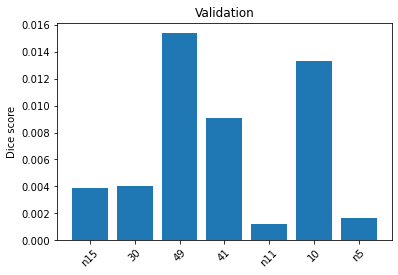

In [343]:
val_labels = val_dataset_whole.labels
plt.ion()
plt.figure()
plt.bar(val_labels, dices)
exp_name = logdir.split('/')[1]
plt.title(f'Validation')
plt.ylabel('Dice score')
plt.xticks(rotation=45)
plt.show()

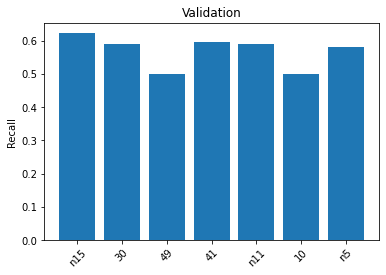

In [344]:
val_labels = val_dataset_whole.labels
plt.ion()
plt.figure()
plt.bar(val_labels, coverages)
exp_name = logdir.split('/')[1]
plt.title(f'Validation')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.show()

In [345]:
labels[ind][0].shape, predicted_labels[ind][0].shape

((1, 183, 268, 228), (1, 183, 268, 228))

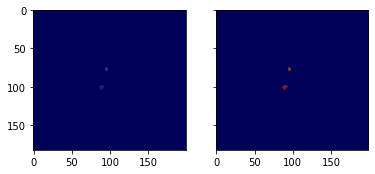

In [346]:
ind = np.argmax(coverages)
plt.ioff()
camera = video_comparison([brains[ind][0,9], brains[ind][0,9]], 
                          [labels[ind][0,0], predicted_labels[ind][0,0]], 
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

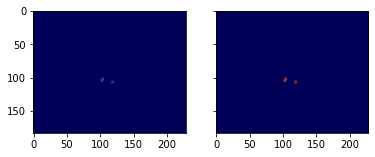

In [347]:
ind = np.argmin(coverages)
plt.ioff()
camera = video_comparison([brains[ind][0,9], brains[ind][0,9]], 
                          [labels[ind][0,0], predicted_labels[ind][0,0]], 
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation